In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from rcgp.rcgp import GPRegressor, RCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, LinearMean
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

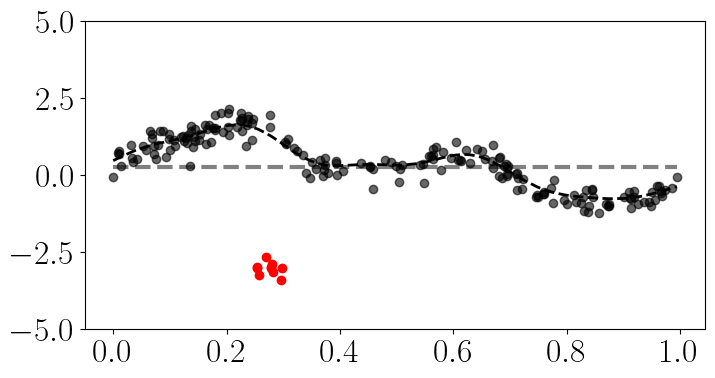

In [2]:
np.random.seed(13)

# Initialisation
epsilon = 0.05
n_points = 200
length_scale = 0.1
variance = 0.5
noise_variance = 0.09

# Simulation
mean_func = ConstantMean(constant=0)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=variance)

x_train = np.sort(np.random.uniform(0, 1.0, n_points)).reshape(-1, 1)
K_train = rbf_kernel(x_train, x_train)
f_train = np.random.multivariate_normal(mean_func(x_train).flatten(), K_train).reshape(-1, 1)
y_train = f_train + np.random.normal(0, np.sqrt(noise_variance), size=x_train.shape)

# Add outliers
outlier_range = np.where((x_train >= 0.25) & (x_train <= 0.3))[0]
outlier_indices = np.sort(np.random.choice(outlier_range, int(n_points * epsilon), replace=False))
outlier_values = np.random.normal(loc=-3, scale=0.2, size=outlier_indices.shape[0])
y_train[outlier_indices] = outlier_values.reshape(-1,1)

mean_y_train = np.mean(y_train)

# Mask to keep all indices that are NOT outliers
mask = np.ones(len(x_train), dtype=bool)
mask[outlier_indices] = False

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x_train, mean_y_train * np.ones(len(x_train)), '--', color='grey', linewidth=3)
plt.plot(x_train[mask], y_train[mask], 'o', color='black', markersize=6, alpha=0.6)  # darker grey, slightly transparent
plt.plot(x_train[~mask], y_train[~mask], 'o', color='red', markersize=6)               # red dots
plt.plot(x_train, f_train, '--', color='black', linewidth=2)                              # thicker true function

plt.ylim(-5, 5)
plt.show()

length_scale=1.0, noise=0.08999999999999998, rbf_variance=0.5
Min eigenvalue of loo_Kw: 0.09010000260963724
LOSS=-940.7923786052354
length_scale=1.00000001, noise=0.08999999999999998, rbf_variance=0.5
Min eigenvalue of loo_Kw: 0.09010000260963745
LOSS=-940.792378560391
length_scale=1.0, noise=0.09000000089999997, rbf_variance=0.5
Min eigenvalue of loo_Kw: 0.09010000350963723
LOSS=-940.7923691725198
length_scale=1.0, noise=0.08999999999999998, rbf_variance=0.5000000050000001
Min eigenvalue of loo_Kw: 0.09010000260963734
LOSS=-940.7923786049332
length_scale=88.62779538060003, noise=999999.9999999995, rbf_variance=0.5153395788285243
Min eigenvalue of loo_Kw: 1000000.0289698099


c:\Users\joshu\Desktop\uni\thesis_UCL\robust_conjugate_MOGP\rcgp\rcgp.py:206: RuntimeWarning: invalid value encountered in log
  predictive_log_prob = -0.5 * np.log(loo_var) - 0.5 * (loo_mean - self.y_train)**2/loo_var - 0.5 * np.log(np.pi * 2)


LOSS=nan
length_scale=88.62779626687798, noise=999999.9999999995, rbf_variance=0.5153395788285243
Min eigenvalue of loo_Kw: 1000000.0289698102
LOSS=nan
length_scale=88.62779538060003, noise=999999.9899999987, rbf_variance=0.5153395788285243
Min eigenvalue of loo_Kw: 1000000.01896981
LOSS=nan
length_scale=88.62779538060003, noise=999999.9999999995, rbf_variance=0.5153395839819201
Min eigenvalue of loo_Kw: 1000000.0289698098
LOSS=nan
Optimized length_scale: 1.0000, noise: 0.090000, rbf_variance: 0.5000
length_scale=1.0, noise=0.08999999999999998, rbf_variance=0.5
Min eigenvalue of loo_Kw: 0.09010000260963724
LOSS=-560.6691062390652
length_scale=1.00000001, noise=0.08999999999999998, rbf_variance=0.5
Min eigenvalue of loo_Kw: 0.09010000260963745
LOSS=-560.6691062355258
length_scale=1.0, noise=0.09000000089999997, rbf_variance=0.5
Min eigenvalue of loo_Kw: 0.09010000350963723
LOSS=-560.6691007989489
length_scale=1.0, noise=0.08999999999999998, rbf_variance=0.5000000050000001
Min eigenvalue

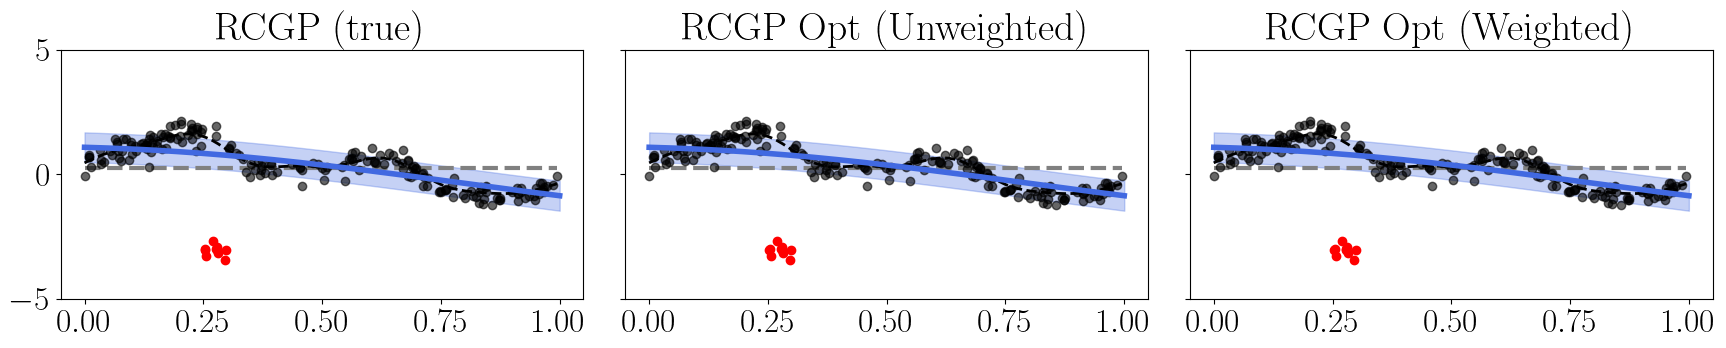

In [3]:
initial_length_scale = 1
initial_rbf_variance = 0.5
initial_noise = 0.09

# Create subplot figure with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

# --- Plot 1: RCGP with weighted LOO-CV not optimized ---
prior_mean = ConstantMean(constant=mean_y_train)
rcgp_w = RCGPRegressor(mean=prior_mean, length_scale=initial_length_scale, rbf_variance=initial_rbf_variance, noise=initial_noise, epsilon=epsilon)
rcgp_w.fit(x_train, y_train)

mu_w, var_w = rcgp_w.predict(x_test)
std_w = np.sqrt(var_w + rcgp_w.noise)

axs[0].plot(x_train, mean_y_train * np.ones(len(x_train)), '--', color='grey', linewidth=3)
axs[0].plot(x_train[mask], y_train[mask], 'o', color='black', markersize=6, alpha=0.6)
axs[0].plot(x_train[~mask], y_train[~mask], 'o', color='red', markersize=6)
axs[0].plot(x_train, f_train, '--', color='black', linewidth=2)
axs[0].plot(x_test, mu_w.ravel(), color="royalblue")
axs[0].fill_between(x_test.ravel(), mu_w.ravel() - 1.96 * std_w, mu_w.ravel() + 1.96 * std_w, alpha=0.3, color='royalblue')
axs[0].set_title("RCGP (true)")

# --- Plot 2: RCGP with unweighted LOO-CV optimization ---
rcgp = RCGPRegressor(mean=prior_mean, length_scale=initial_length_scale, rbf_variance=initial_rbf_variance, noise=initial_noise, epsilon=epsilon)
rcgp.fit(x_train, y_train)
rcgp.optimize_loo_cv(weighted=False, print_opt_param=True, print_iter_param=True)

mu, var = rcgp.predict(x_test)
std = np.sqrt(var + rcgp.noise)

axs[1].plot(x_train, mean_y_train * np.ones(len(x_train)), '--', color='grey', linewidth=3)
axs[1].plot(x_train[mask], y_train[mask], 'o', color='black', markersize=6, alpha=0.6)
axs[1].plot(x_train[~mask], y_train[~mask], 'o', color='red', markersize=6)
axs[1].plot(x_train, f_train, '--', color='black', linewidth=2)
axs[1].plot(x_test, mu.ravel(), color="royalblue")
axs[1].fill_between(x_test.ravel(), mu.ravel() - 1.96 * std, mu.ravel() + 1.96 * std, alpha=0.3, color='royalblue')
axs[1].set_title("RCGP Opt (Unweighted)")

# --- Plot 3: RCGP with weighted LOO-CV optimization ---
rcgp_w = RCGPRegressor(mean=prior_mean, length_scale=initial_length_scale, rbf_variance=initial_rbf_variance, noise=initial_noise, epsilon=epsilon)
rcgp_w.fit(x_train, y_train)
rcgp_w.optimize_loo_cv(weighted=True, print_opt_param=True, print_iter_param=True, power=1)

# print(rcgp_w.loo_cv(weighted=True, length_scale=initial_length_scale, rbf_variance=initial_rbf_variance, noise=initial_noise))

mu_w, var_w = rcgp_w.predict(x_test)
std_w = np.sqrt(var_w + rcgp_w.noise)

axs[2].plot(x_train, mean_y_train * np.ones(len(x_train)), '--', color='grey', linewidth=3)
axs[2].plot(x_train[mask], y_train[mask], 'o', color='black', markersize=6, alpha=0.6)
axs[2].plot(x_train[~mask], y_train[~mask], 'o', color='red', markersize=6)
axs[2].plot(x_train, f_train, '--', color='black', linewidth=2)
axs[2].plot(x_test, mu_w.ravel(), color="royalblue")
axs[2].fill_between(x_test.ravel(), mu_w.ravel() - 1.96 * std_w, mu_w.ravel() + 1.96 * std_w, alpha=0.3, color='royalblue')
axs[2].set_title("RCGP Opt (Weighted)")

# Common settings
for ax in axs:
    ax.set_ylim(-5, 5)

plt.tight_layout()
plt.show()
